In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

In [3]:
stats = pd.read_csv("/kaggle/input/image-dimensions/image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2800.000000,2800.000000
mean,603.034286,647.997143
std,415.862944,446.696660
min,106.000000,115.000000
25%,313.000000,383.000000
50%,547.500000,589.500000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,546.000000,589.000000


In [4]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [5]:
def build_model(width, height):
    model = keras.Sequential([
        layers.InputLayer(shape=(width, height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 546, 589, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 544, 587, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 272, 293, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 270, 291, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 135, 145, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 133, 143, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 66, 71, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 69, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         245,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224,257 (4.67 MB)

 Trainable params: 1,224,257 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [7]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

## Undersampled dataset:

### Data inladen:

In [8]:
painters = ["Mondriaan", "Picasso"]
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/undersampled_dataset/undersampled_dataset", painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


### Model trainen

In [9]:
model = build_model(median_width, median_height)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 546, 589, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 544, 587, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 272, 293, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 270, 291, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 135, 145, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 133, 143, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 66, 71, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 69, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 30, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         245,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224,257 (4.67 MB)

 Trainable params: 1,224,257 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.5529 - loss: 7940592640.0000 - val_accuracy: 0.5000 - val_loss: 73880.1250
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5741 - loss: 30231.7930 - val_accuracy: 0.5000 - val_loss: 26499.1660
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4343 - loss: 12129.8672 - val_accuracy: 0.5000 - val_loss: 650.4324
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5197 - loss: 1025.9719 - val_accuracy: 0.5000 - val_loss: 1183.0135
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5013 - loss: 20905.5391 - val_accuracy: 0.4314 - val_loss: 113.7663
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5619 - loss: 43.6202 - val_accuracy: 0.5588 - val_loss: 1.0354
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5100 - loss: 0.7493 - val_accuracy: 0.4706 - val_loss: 0.7583
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy:

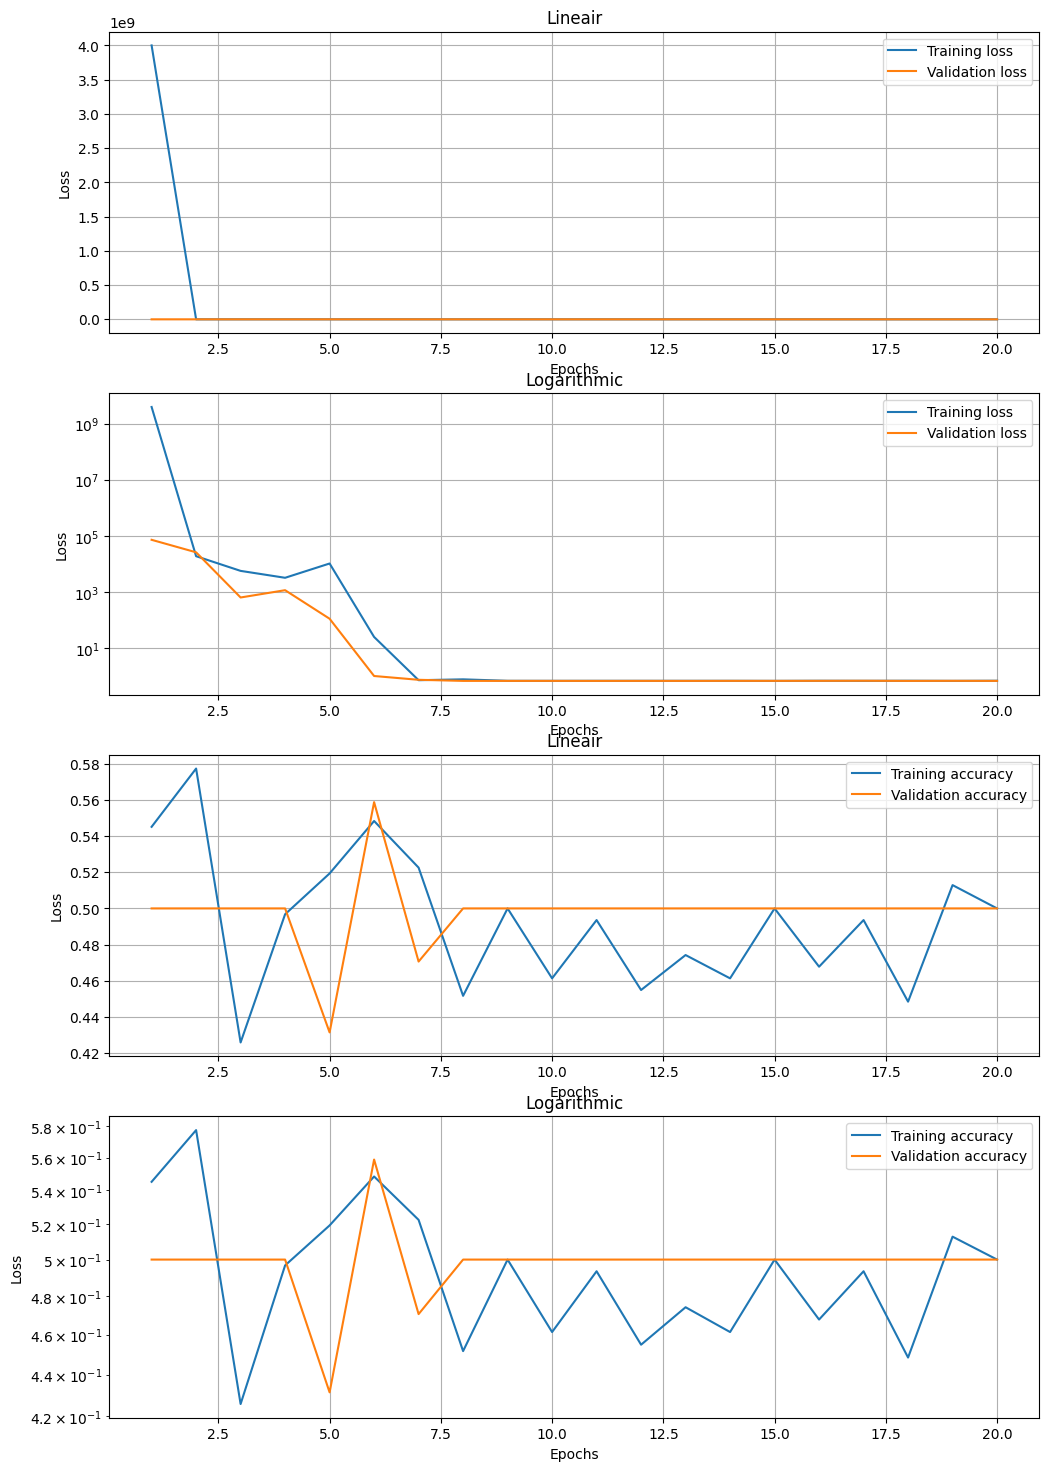

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.50      1.00      0.67        51

    accuracy                           0.50       102
   macro avg       0.25      0.50      0.33       102
weighted avg       0.25      0.50      0.33       102



## Oversampled dataset

### loading data

In [13]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/oversampled_dataset/oversampled_dataset", painters, median_height, median_width, batch_size=16)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.5172 - loss: 1.1904 - val_accuracy: 0.5000 - val_loss: 1.8077
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5893 - loss: 0.7645 - val_accuracy: 0.6230 - val_loss: 0.6114
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.7000 - loss: 0.5990 - val_accuracy: 0.7639 - val_loss: 0.4871
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.7694 - loss: 0.5196 - val_accuracy: 0.7557 - val_loss: 0.4728
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8572 - loss: 0.3246 - val_accuracy: 0.8689 - val_loss: 0.3526
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9120 - loss: 0.2092 - val_accuracy: 0.8934 - val_loss: 0.3295
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9346 - loss: 0.1972 - va

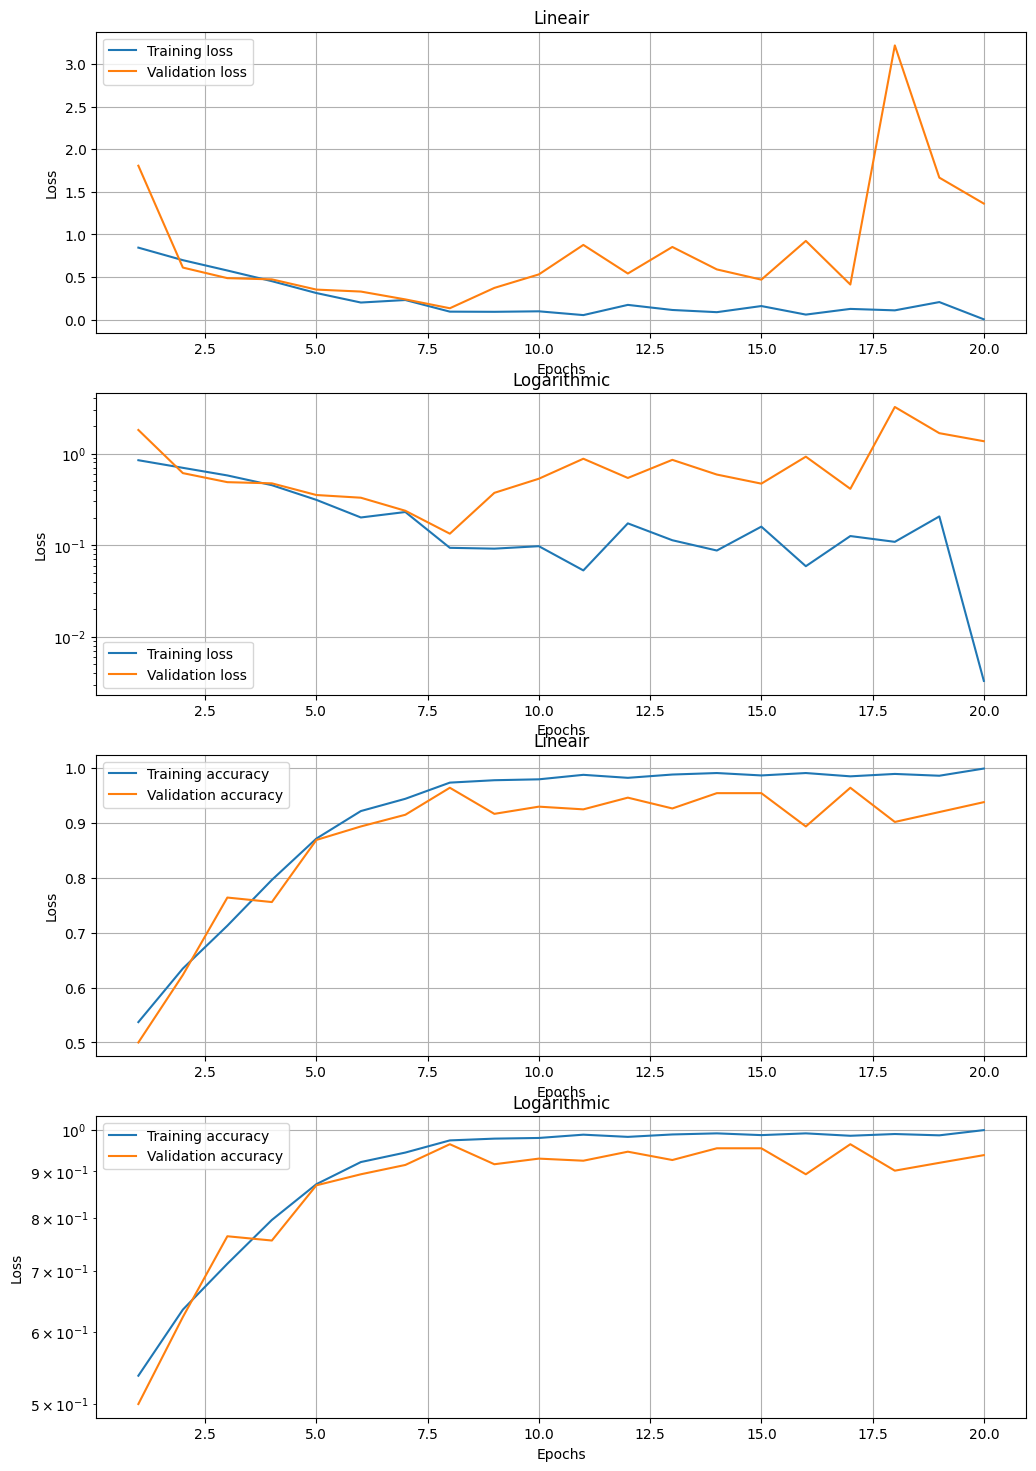

In [14]:
plot_loss(history)

In [15]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       305
           1       0.50      0.45      0.47       305

    accuracy                           0.50       610
   macro avg       0.50      0.50      0.50       610
weighted avg       0.50      0.50      0.50       610



## imbalanced dataset

### loading dataset

In [16]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset", painters, median_width, median_height, batch_size=16)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


### Fitting model 

Mondriaan = 0, Picasso = 1

In [17]:
train.class_names

['Mondriaan', 'Picasso']

In [18]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {1: 917, 0: 198})

In [19]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight


{0: 2.8156565656565657, 1: 0.6079607415485279}

In [20]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.5504 - loss: 2.3854 - val_accuracy: 0.7790 - val_loss: 0.6370
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5886 - loss: 0.7494 - val_accuracy: 0.1779 - val_loss: 0.8954
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5184 - loss: 0.7789 - val_accuracy: 0.2318 - val_loss: 0.9394
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6165 - loss: 0.7445 - val_accuracy: 0.8356 - val_loss: 0.3895
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6454 - loss: 0.7199 - val_accuracy: 0.7682 - val_loss: 0.5249
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7298 - loss: 0.6860 - val_accuracy: 0.7278 - val_loss: 0.5211
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7316 - loss: 0.5699 - val_accuracy: 0.6523 - val_loss: 0.5991
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7354 - loss: 0.4892 - val_accuracy: 0

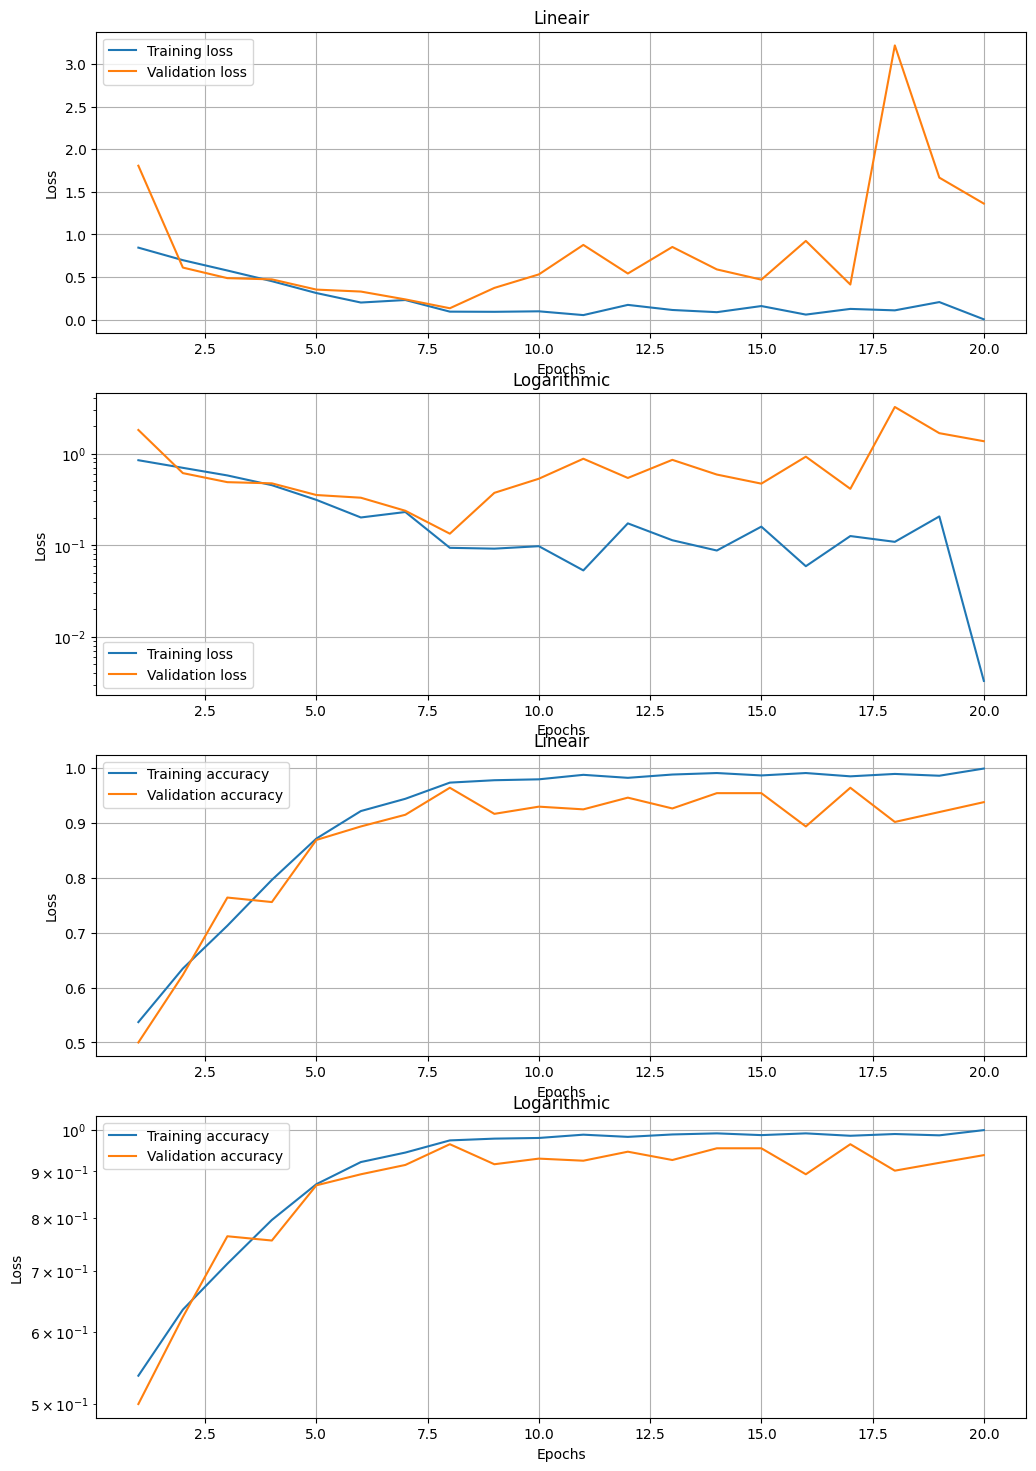

In [21]:
plot_loss(history)

In [22]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        66
           1       0.83      0.85      0.84       305

    accuracy                           0.73       371
   macro avg       0.52      0.51      0.51       371
weighted avg       0.72      0.73      0.72       371



Image size bepalen

In [23]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1]
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 115, 'train_accuracy': 0.9784753322601318, 'val_accuracy': 0.9460916519165039, 'train_loss': 0.08412675559520721, 'val_loss': 0.17106905579566956}
min nearest
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 115, 'train_accuracy': 0.9775784611701965, 'val_accuracy': 0.8948786854743958, 'train_loss': 0.09276525676250458, 'val_loss': 0.2961104214191437}
min bicubic
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
{'statistic': 'min', 'interpolation': 'bicubic', 'width': 106, 'height': 115, 'train_accuracy': 0.9757847785949707, 'val_accuracy': 0.9245283007621765, 'train_l

In [25]:
df.sort_values("val_loss")

,statistic,interpolation,width,height,train_accuracy,val_accuracy,train_loss,val_loss
0,min,bilinear,106,115,0.978475,0.946092,0.084127,0.171069
5,min,lanczos5,106,115,0.968610,0.946092,0.080678,0.216879
4,min,lanczos3,106,115,0.966816,0.935310,0.095755,0.220266
9,25%,bicubic,313,383,0.944395,0.943396,0.151018,0.264865
1,min,nearest,106,115,0.977578,0.894879,0.092765,0.296110
2,min,bicubic,106,115,0.975785,0.924528,0.100709,0.298719
11,25%,lanczos3,313,383,0.956951,0.964960,0.128947,0.320496
16,median,bicubic,546,589,0.972197,0.924528,0.139131,0.348242
8,25%,nearest,313,383,0.958744,0.938005,0.129146,0.356340
10,25%,area,313,383,0.985650,0.943396,0.108153,0.360023


In [26]:
df.to_csv("gridsearch_result.csv")